In [ ]:
### This code solves compressible 1D Navier-Stokes equation when the gas is initially confined in some region
### And is allowed to expand into vaccum from both sides


### Author: Archisman Panigrahi (archi137@mit.edu)
### License: MIT License

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Set the fluid properties and flow conditions
rho = 1.0  # density
nu = 0.005   # viscosity
u = 1.0    # velocity
L = 4.0    # length
gamma = 1.66  # adiabatic index

# Set the number of grid points and the grid spacing
nx = 201
dx = L / nx

# Set the timestep size and the number of timesteps
# dt = 0.001
t_final = 2.0

nt = 31000  # maximum number of timesteps

Text(0.5, 0, 'Grid Point')

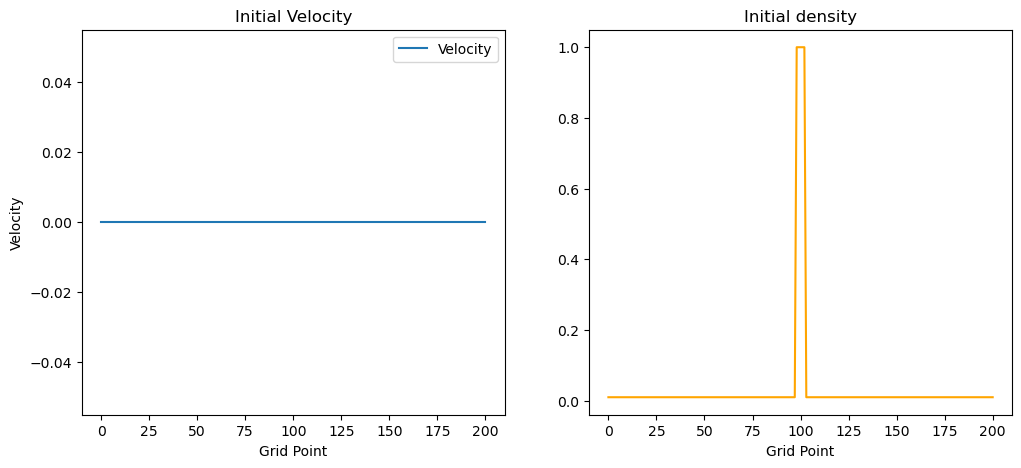

In [24]:
# Set the initial velocity and density
u_initial = np.zeros(nx)
rho_initial = np.zeros(nx)
# Continuous (Gaussian) function for density in the middle
x = np.linspace(0, L, nx)
center = L / 2
width = L / 40
# rho_initial = 0.5 * (2-np.tanh((np.abs(x - center)) / width))

# Step function for density in the middle
rho_initial = np.where(
    np.abs(x - center) < width / 2,
    1.0,   # value inside the step
    0.01    # value outside the step
)

## Plot the initial conditions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(u_initial, label='Velocity')
plt.title('Initial Velocity')
plt.xlabel('Grid Point')
plt.ylabel('Velocity')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(rho_initial, label='Density', color='orange')
plt.title('Initial density')
plt.xlabel('Grid Point')


In [ ]:
# Create arrays to store the solution at each timestep
u_solution = np.zeros((nt, nx))
rho_solution = np.zeros((nt, nx))

p_solution = np.zeros(nx)

# Set the initial conditions
u_solution[0] = u_initial
rho_solution[0] = rho_initial

epsilon = 1e-4  # small value to prevent division by zero

t_series = np.zeros(nt)

# Solve the Navier-Stokes equation using the finite difference method
for iii in range(nt - 1):

    dt = min(0.2 * dx / np.max(np.abs(u_solution[iii]) + epsilon), 0.2* dx*dx/(nu+epsilon),  0.0001)  # CFL (Courant–Friedrichs–Lewy) condition for convergence of this PDE
    t_series[iii+1] = t_series[iii] + dt
    t = t_series[iii]
    p_solution = np.array(rho_solution[iii]) ** gamma

    # Update velocity
    for i in range(1, nx - 1):
        ## Density can be zero, so I take an average of three nearby densities so nothing bad happens at the jump
        u_solution[iii + 1, i] = (
            u_solution[iii, i]
            - dt * u_solution[iii, i] * (u_solution[iii, i + 1] - u_solution[iii, i - 1]) / (2 * dx)
            - 3 * dt / ((rho_solution[iii, i - 1] + rho_solution[iii, i] + rho_solution[iii, i + 1]) * 2 * dx) * (p_solution[i+1] - p_solution[i - 1])
            + nu * dt / dx**2 * (u_solution[iii, i + 1] - 2 * u_solution[iii, i] + u_solution[iii, i - 1])
        )

    # Periodic boundary conditions for velocity
    u_solution[iii + 1, 0] = u_solution[iii + 1, -2]
    u_solution[iii + 1, -1] = u_solution[iii + 1, 1]

    # Update density using upwind scheme
    for i in range(1, nx - 1):
        # Upwind: choose direction based on velocity
        if u_solution[iii, i] > 0:
            flux = u_solution[iii, i] * rho_solution[iii, i]
            flux_prev = u_solution[iii, i - 1] * rho_solution[iii, i - 1]
        else:
            flux = u_solution[iii, i + 1] * rho_solution[iii, i + 1]
            flux_prev = u_solution[iii, i] * rho_solution[iii, i]

        rho_solution[iii + 1, i] = (
            rho_solution[iii, i]
            - dt / dx * (flux - flux_prev)
        )

    # Periodic boundary conditions for density
    rho_solution[iii + 1, 0] = rho_solution[iii + 1, -2]
    rho_solution[iii + 1, -1] = rho_solution[iii + 1, 1]

    # Warn if any density becomes negative or zero and show positions
    negative_density_number = np.where(rho_solution[iii + 1] < 0)[0]
    if negative_density_number.size > 0:
        print(f"Warning: Density <= 0 detected at timestep {t+1} at positions {negative_density_number}")
        break
    if t > t_final:
        print(f"Reached final time at timestep {iii+1}, t = {t}")
        final_time_index = iii + 1
        break

# Plot the velocity solution
plt.plot(u_solution[final_time_index])
plt.xlabel("Grid point")
plt.ylabel("Velocity")
plt.show()

# Plot the pressure solution
plt.plot(rho_solution[final_time_index])
plt.xlabel("Grid point")
plt.ylabel("Density")
plt.show()

In [ ]:
final_time_index

20002

In [ ]:
t

0.4910354504479173

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Ensure final_time_index is defined
try:
    final_time_index
except NameError:
    final_time_index = nt

space = np.arange(u_solution.shape[1])

def plot_u_rho(time_idx):
    fig, axs = plt.subplots(3, 1, figsize=(4, 6), sharex=True)
    # 1. Velocity
    axs[0].plot(space, u_solution[time_idx], lw=2)
    axs[0].set_ylabel('Velocity (u)')
    axs[0].set_title(f'Velocity Profile (Time Index: {t_series[time_idx]})')
    # 2. Second derivative of velocity
    u = u_solution[time_idx]
    d2u_dx2 = np.zeros_like(u)
    d2u_dx2[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    d2u_dx2[0] = (u[1] - 2 * u[0] + u[-2]) / dx**2
    d2u_dx2[-1] = d2u_dx2[0]
    axs[1].plot(space, d2u_dx2, lw=2, color='green')
    axs[1].set_ylabel('d²u/dx²')
    axs[1].set_title('Numerical Second Derivative of Velocity')
    # 3. Density
    axs[2].plot(space, rho_solution[time_idx], lw=2, color='orange')
    axs[2].set_xlabel('Space Index')
    axs[2].set_ylabel('Density (rho)')
    axs[2].set_title(f'Density Profile (Time: {t_series[time_idx]})')

    plt.tight_layout()
    plt.show()

slider = widgets.IntSlider(
    value=0,
    min=0,
    max=final_time_index-1,
    step=1,
    description='Time Index'
)

widgets.interact(plot_u_rho, time_idx=slider)

interactive(children=(IntSlider(value=0, description='Time Index', max=20001), Output()), _dom_classes=('widge…

<function __main__.plot_u_rho(time_idx)>

In [ ]:
final_time_index

20002